# Website Traffic Forecasting




## Importing Packages

In [2]:
# Importing all the necessary packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Functions for Modularising the code



In [3]:
# Load the web traffic data from a CSV file
def load_data(csv_file):
    # Read the CSV file using pandas and store it in the 'data' DataFrame
    data = pd.read_csv(csv_file)

    # Convert the "Hour Index" column to a DatetimeIndex with hourly frequency
    # This will make it easier to work with time series data
    data['Hour Index'] = pd.to_datetime('2023-07-18') + pd.to_timedelta(data['Hour Index'], unit='h')
    data.set_index('Hour Index', inplace=True)

    return data


# Decompose the time series to check for seasonality
def decompose_series(data):
    # Use the seasonal_decompose function from statsmodels to decompose the time series
    # 'additive' model is used to capture the seasonality by adding seasonal components
    decomposition = sm.tsa.seasonal_decompose(data['Sessions'], model='additive')

    # Extract the trend, seasonal, and residual components from the decomposition
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return trend, seasonal, residual

# Perform ARIMA/SARIMA forecasting
def arima_forecast(data, order, seasonal_order=None, forecast_periods=30):
    # Create an ARIMA (AutoRegressive Integrated Moving Average) model using the provided order and seasonal_order
    # 'freq' is set to 'H' to specify hourly frequency for the time series
    model = sm.tsa.ARIMA(data['Sessions'], order=order, seasonal_order=seasonal_order, freq='H')

    # Fit the model to the data and obtain the forecast for the specified number of periods
    results = model.fit()
    forecast = results.forecast(steps=forecast_periods)

    return forecast, results

# Calculate forecast accuracy using Mean Absolute Percentage Error (MAPE)
def calculate_accuracy(test_data, forecast):
    # Calculate the absolute percentage errors for each period
    abs_percentage_errors = np.abs((test_data - forecast) / test_data)

    # Calculate the mean of absolute percentage errors and convert it to a percentage
    mape = np.mean(abs_percentage_errors) * 100

    return mape

## Web-Traffic Data

In [6]:
# Load data from the CSV file
data = load_data('Web_Data.csv')
print(data)

                       Sessions
Hour Index                     
2023-07-18 00:00:00  1418159421
2023-07-18 01:00:00  1113769116
2023-07-18 02:00:00   919158921
2023-07-18 03:00:00   822352824
2023-07-18 04:00:00   735526737
...                         ...
2024-02-03 22:00:00  1852289856
2024-02-03 23:00:00  1710573714
2024-02-04 00:00:00  1562869566
2024-02-04 01:00:00  1330335333
2024-02-04 02:00:00  1189617192

[4827 rows x 1 columns]


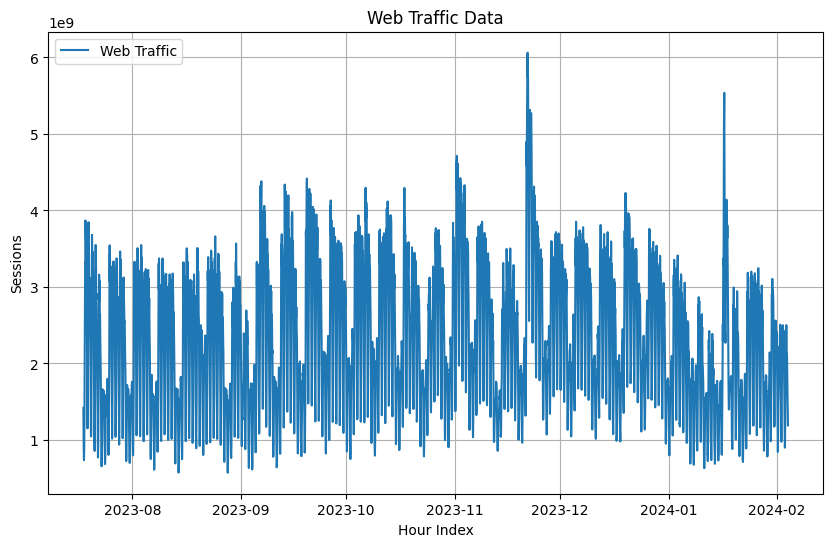

In [7]:
# Plot the web traffic data
# Create a figure with a size of 10x6 inches
plt.figure(figsize=(10, 6))

# Plot the 'Sessions' column against the DatetimeIndex on the y-axis
plt.plot(data.index, data['Sessions'], label='Web Traffic')

# Set labels for the x-axis and y-axis
plt.xlabel('Hour Index')
plt.ylabel('Sessions')

# Set the title of the plot
plt.title('Web Traffic Data')

# Display the legend on the upper left corner
plt.legend(loc='upper left')

# Add grid lines for better readability
plt.grid(True)

# Show the plot
plt.show()

## Analysis

In [12]:
# Decompose the time series to check for seasonality
trend, seasonal, residual = decompose_series(data)

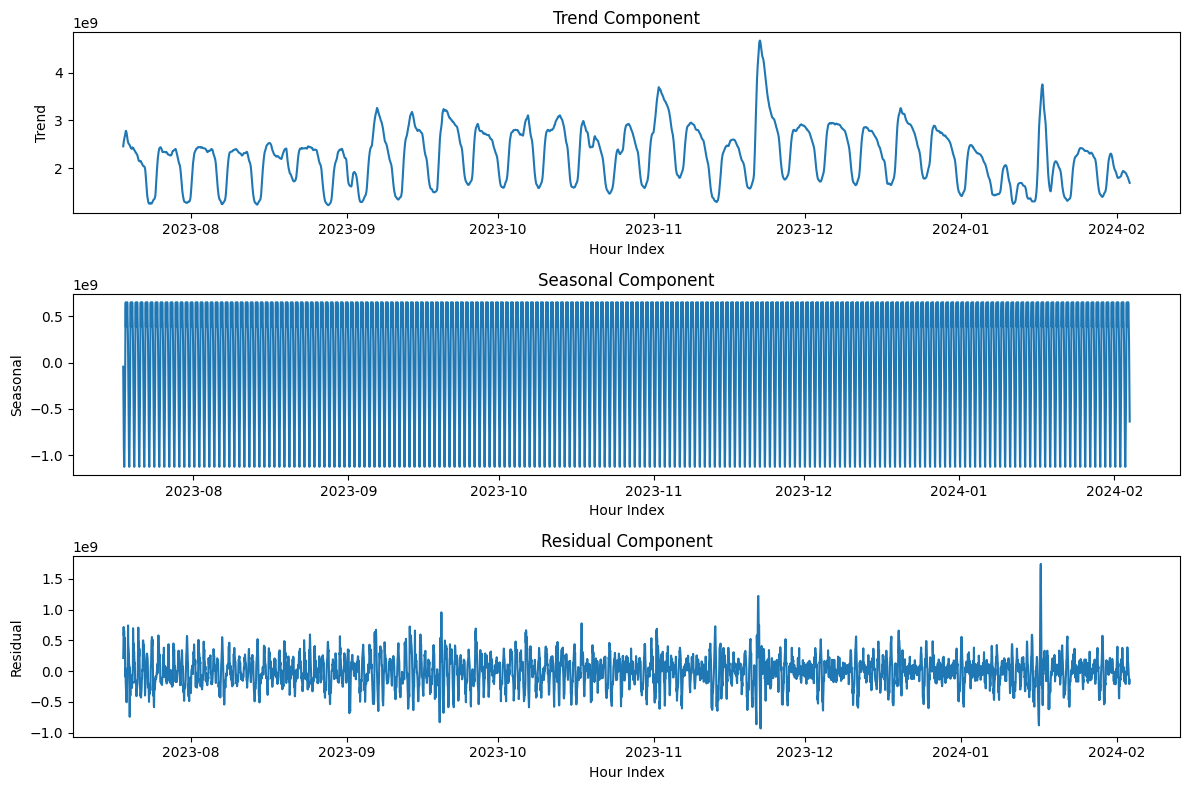

In [9]:
# Plot the decomposed components
plt.figure(figsize=(12, 8))

# Plot the Trend component
plt.subplot(3, 1, 1)
plt.plot(trend)
plt.xlabel('Hour Index')
plt.ylabel('Trend')
plt.title('Trend Component')

# Plot the Seasonal component
plt.subplot(3, 1, 2)
plt.plot(seasonal)
plt.xlabel('Hour Index')
plt.ylabel('Seasonal')
plt.title('Seasonal Component')

# Plot the Residual component
plt.subplot(3, 1, 3)
plt.plot(residual)
plt.xlabel('Hour Index')
plt.ylabel('Residual')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

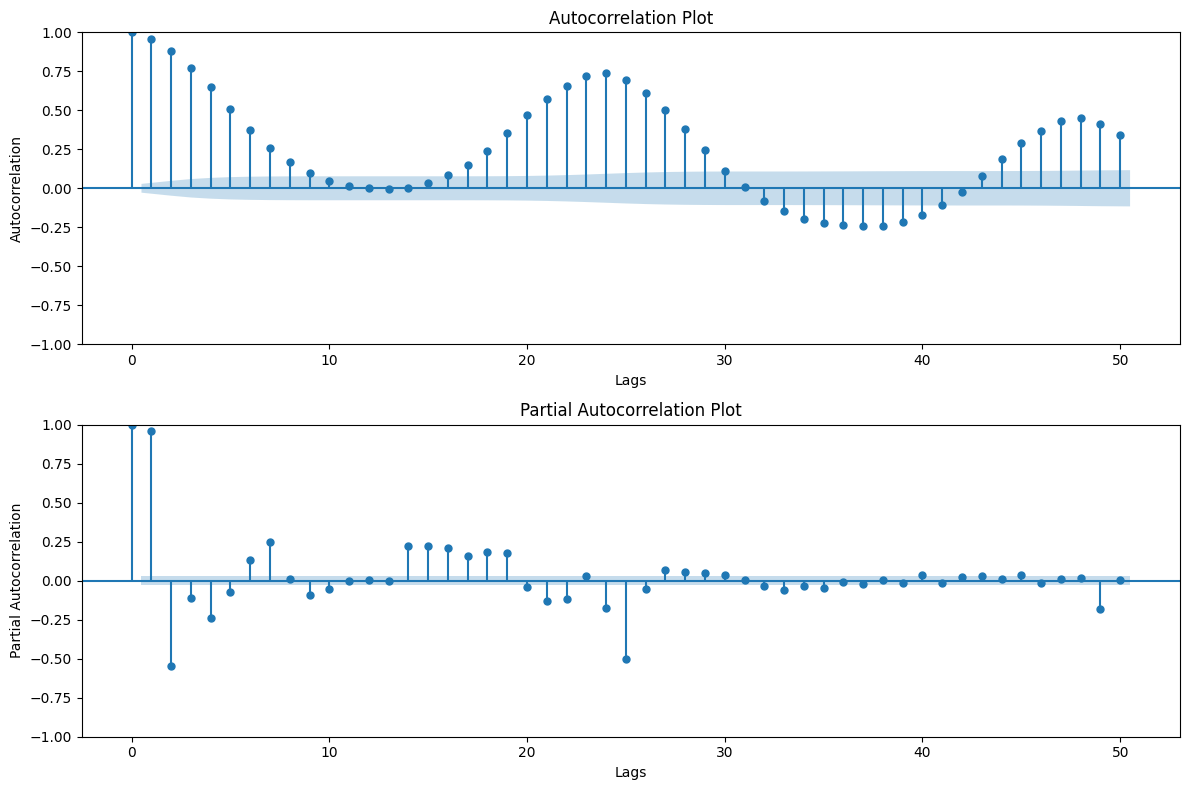

In [11]:
# Autocorrelation and Partial Autocorrelation plots
plt.figure(figsize=(12, 8))

# Autocorrelation plot
plt.subplot(2, 1, 1)
plot_acf(data['Sessions'], lags=50, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')

# Partial Autocorrelation plot
plt.subplot(2, 1, 2)
plot_pacf(data['Sessions'], lags=50, ax=plt.gca())
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')

plt.tight_layout()
plt.show()

## ARIMA and SARIMA

In [13]:
# Define ARIMA order and seasonal_order
order = (2, 1, 0)  # (p, d, q)
seasonal_order = (1, 1, 1, 24)  # (P, D, Q, S)

# Forecast the last 30 values using ARIMA
train_data = data.iloc[:-30]
test_data = data.iloc[-30:]
train_forecast, model_results = arima_forecast(train_data, order, seasonal_order, 30)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [14]:
# Show the ARIMA model summary
print(model_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Sessions   No. Observations:                 4797
Model:             ARIMA(2, 1, 0)x(1, 1, [1], 24)   Log Likelihood              -96175.495
Date:                            Thu, 14 Dec 2023   AIC                         192360.990
Time:                                    10:52:52   BIC                         192393.342
Sample:                                07-18-2023   HQIC                        192372.355
                                     - 02-02-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0812      0.016      4.998      0.000       0.049       0.113
ar.L2          0.0405      0.022   

### Results

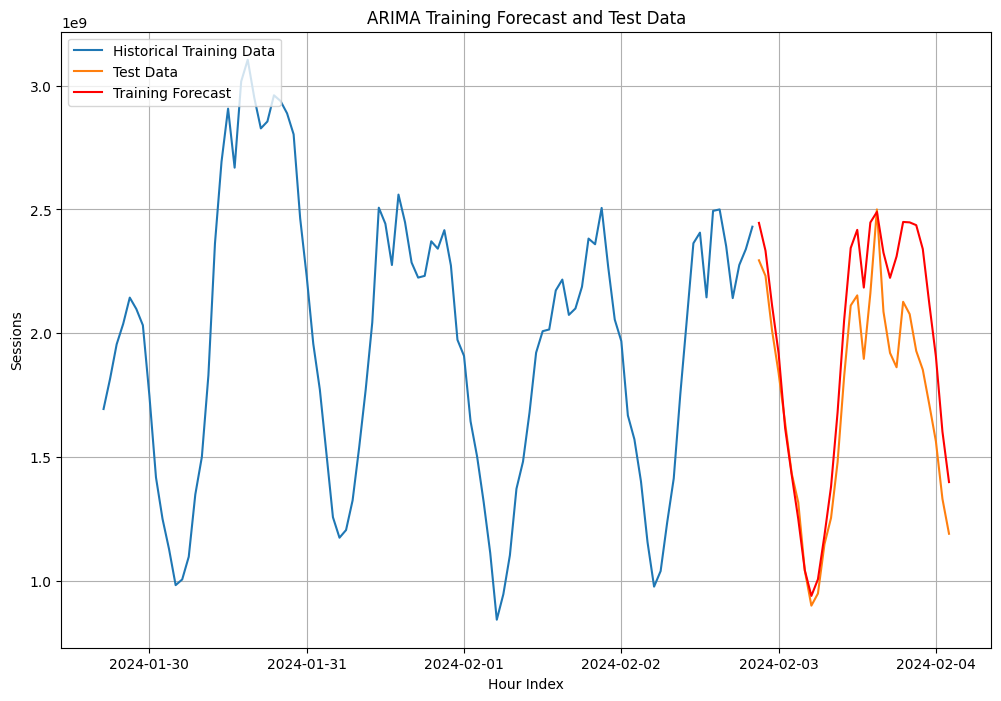

In [15]:
# Plot the training forecast and the test data
plt.figure(figsize=(12, 8))

# Plot the historical training data
plt.plot(train_data.index[-100:], train_data['Sessions'].tail(100), label='Historical Training Data')

# Plot the test data
plt.plot(test_data.index, test_data['Sessions'], label='Test Data')

# Plot the forecast for the test data
plt.plot(test_data.index[:30], train_forecast, label='Training Forecast', color='red')

# Set labels and title
plt.xlabel('Hour Index')
plt.ylabel('Sessions')
plt.title('ARIMA Training Forecast and Test Data')
plt.legend(loc='upper left')
plt.grid(True)  # Add grid lines for better readability
plt.show()

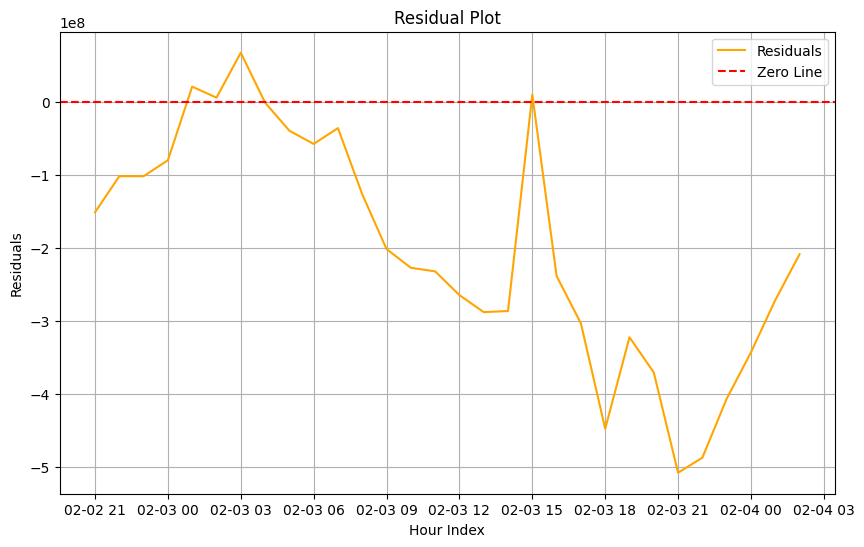

In [16]:
# Residual plot
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Sessions'] - train_forecast, label='Residuals', color='orange')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.xlabel('Hour Index')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

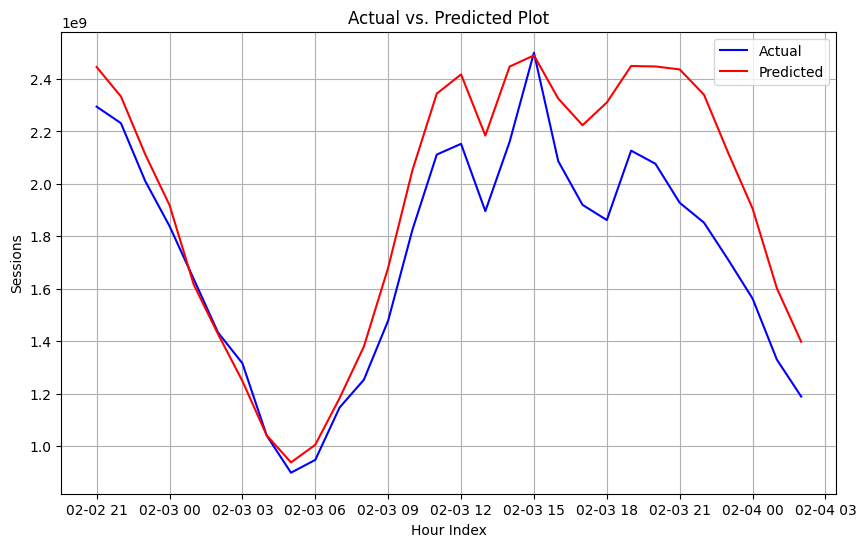

In [17]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Sessions'], label='Actual', color='blue')
plt.plot(test_data.index[:30], train_forecast, label='Predicted', color='red')
plt.xlabel('Hour Index')
plt.ylabel('Sessions')
plt.title('Actual vs. Predicted Plot')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Calculate forecast accuracy for the last 30 values
accuracy = calculate_accuracy(test_data['Sessions'], train_forecast)
print(f'ARIMA Model Error (MAPE) for the last 30 values: {accuracy:.2f}%')
print('The lower the value of the Mean Absolute Percentage Error, the better the prediction of the model')


ARIMA Model Error (MAPE) for the last 30 values: 11.67%
The lower the value of the Mean Absolute Percentage Error, the better the prediction of the model
